In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

In [2]:
# Load dataset
file_path = "/content/drive/MyDrive/Minor_project6thsem/Datasets/DDoS SDN Tree/DDoS-SDN-Tree star.xlsx"
df = pd.read_excel(file_path)

<ipython-input-3-b997d77631fc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette="coolwarm")


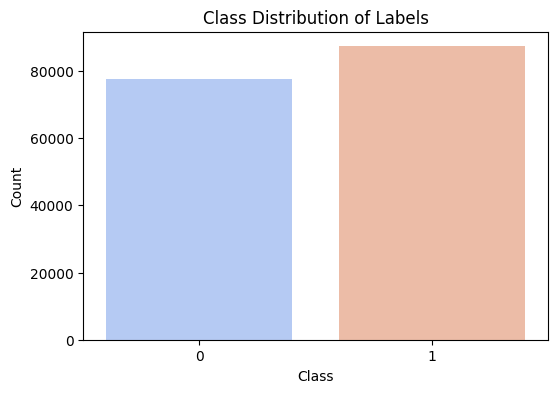

In [3]:
# Visualize Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['label'], palette="coolwarm")
plt.title("Class Distribution of Labels")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [4]:
# Convert numerical columns (fix European-style decimal issues)
for col in df.columns:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(str)
    try:
        df[col] = pd.to_numeric(df[col])
    except ValueError:
        pass  # Ignore non-numeric columns


In [5]:
# Preprocess dataset
# Drop unnecessary columns
columns_to_drop = ['src', 'dst', 'eth.src', 'eth.dst', 'frame.time_epoch', 'Pairflow', 'byteperflow']
df_cleaned = df.drop(columns=[col for col in columns_to_drop if col in df.columns])


In [6]:
# Encode categorical variables
label_encoder = LabelEncoder()
df_cleaned['Protocol'] = label_encoder.fit_transform(df_cleaned['Protocol'])
df_cleaned['label'] = label_encoder.fit_transform(df_cleaned['label'])

In [7]:
# Define features and target
X = df_cleaned.drop(columns=['label']).values
y = df_cleaned['label'].values


In [8]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [11]:
# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

In [12]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [13]:
# Create federated data split (simulating clients)
def split_federated_data(X, y, num_clients=5):
    split_size = len(X) // num_clients
    client_datasets = []
    for i in range(num_clients):
        start = i * split_size
        end = (i + 1) * split_size if i != num_clients - 1 else len(X)
        dataset = TensorDataset(X[start:end], y[start:end])
        client_datasets.append(DataLoader(dataset, batch_size=64, shuffle=True))
    return client_datasets

In [14]:
# Create federated client datasets
client_loaders = split_federated_data(X_train_tensor, y_train_tensor, num_clients=5)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

In [15]:
# Define a simplified neural network with stronger regularization
class FedNN(nn.Module):
    def __init__(self, input_size):
        super(FedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.dropout1 = nn.Dropout(0.6)
        self.fc2 = nn.Linear(16, 8)
        self.dropout2 = nn.Dropout(0.6)
        self.fc3 = nn.Linear(8, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [16]:
# Initialize global model
global_model = FedNN(input_size=X_train.shape[1])

In [17]:
# Federated averaging function
def federated_averaging(global_model, client_models):
    global_state_dict = global_model.state_dict()
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.stack([client_models[i].state_dict()[key] for i in range(len(client_models))], dim=0).mean(dim=0)
    global_model.load_state_dict(global_state_dict)

In [18]:
# Training federated clients
def train_federated(global_model, client_loaders, epochs=10):
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        client_models = []
        for client_loader in client_loaders:
            model = FedNN(input_size=X_train.shape[1])
            model.load_state_dict(global_model.state_dict())
            optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=5e-3)
            model.train()
            for X_batch, y_batch in client_loader:
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
            client_models.append(model)
        federated_averaging(global_model, client_models)
        print(f"Epoch {epoch+1}/{epochs} completed.")

In [19]:
# Train federated model
train_federated(global_model, client_loaders, epochs=10)

Epoch 1/10 completed.
Epoch 2/10 completed.
Epoch 3/10 completed.
Epoch 4/10 completed.
Epoch 5/10 completed.
Epoch 6/10 completed.
Epoch 7/10 completed.
Epoch 8/10 completed.
Epoch 9/10 completed.
Epoch 10/10 completed.


In [20]:
# Evaluate model
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.numpy())
            y_pred.extend(predicted.numpy())
            y_probs.extend(probs.numpy())
    acc = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred))
    return y_true, y_pred, y_probs

In [21]:
# Run evaluation
y_true, y_pred, y_probs = evaluate_model(global_model, test_loader)

Test Accuracy: 0.9465
              precision    recall  f1-score   support

           0       0.90      0.99      0.95     23286
           1       0.99      0.91      0.95     26184

    accuracy                           0.95     49470
   macro avg       0.95      0.95      0.95     49470
weighted avg       0.95      0.95      0.95     49470



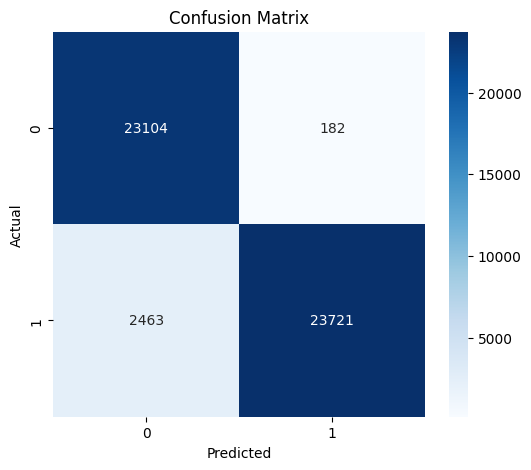

In [22]:
# Confusion matrix
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

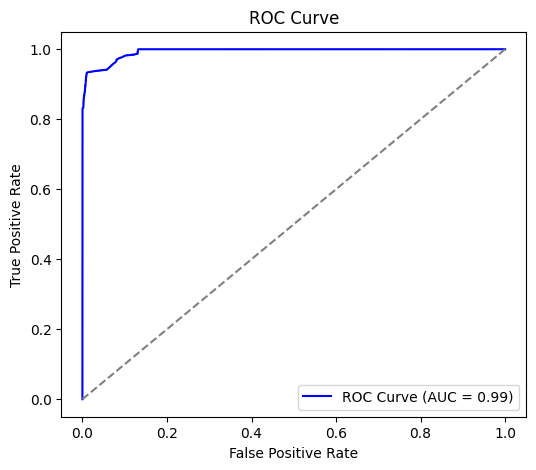

In [23]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

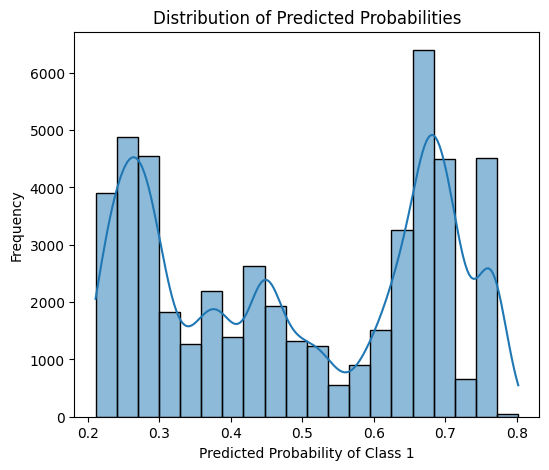

In [24]:
# Distribution of Predictions
plt.figure(figsize=(6,5))
sns.histplot(y_probs, bins=20, kde=True)
plt.xlabel("Predicted Probability of Class 1")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.show()
